## Loading Module and Datasets

In [1]:
import anndata as ad
import numpy as np
import scanpy as sc
import os
from scHSC import scHSCModel
import matplotlib.pyplot as plt


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
dataset = 'Quake_10x_Bladder'
adata_raw = ad.read(f'./data/{dataset}.h5ad')
adata_raw.raw = adata_raw
nclusters = len(np.unique(adata_raw.obs['cluster'])) # or specify another target clusters

# All experiments of scHSC were conducted using CUDA version 10.1. 
# Note that using different CUDA versions may lead to minor variations in the results.
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available()) 

1.8.1+cu101
10.1
True


## scHSC pre-processing
- para adata: Anndata object that contains the gene expression data. 
- para t: Used in the function "laplacian_filtering". 
- para highly_genes: Specify the number of highly variable genes to consider during the normalization step. 
- para k: Number of nearest neighbors to consider when constructing the adjacency matrix.
- para preprocessed: Indicates whether the input data has already been preprocessed.
- para lap__filter: Indicates whether to apply Laplacian filtering to the data.
- para approx: Indicates whether to use an approximate method for constructing the adjacency matrix.
- para lap_sparse: Indicates whether to use a sparse matrix representation for the Laplacian filtering.

In [2]:
log_path = f"./temp/{dataset}_log.txt"
schsc = scHSCModel(log_path=log_path)
adata = schsc.preprocess(adata = adata_raw, t = 1, highly_genes = 2000, k = 18, 
                         preprocessed = False, lap__filter = True, approx = True, lap_sparse = True)

2025-02-16 01:24:54,444 - scHSC - INFO - Create log file...
2025-02-16 01:24:54,445 - scHSC - INFO - Create scHSCModel Object Done...
2025-02-16 01:24:54,449 - scHSC - INFO - Preprocessing data...
2025-02-16 01:24:55,262 - scHSC - INFO - Filtering genes and cells...
2025-02-16 01:24:57,052 - scHSC - INFO - Normalizing data...
2025-02-16 01:24:57,096 - scHSC - INFO - Log1p data...
2025-02-16 01:24:57,391 - scHSC - INFO - Selecting HVG(n_top_genes=2000)...
2025-02-16 01:24:58,459 - scHSC - INFO - Scaling data...
2025-02-16 01:25:01,768 - scHSC - INFO - Constructing approximate adjacency matrix using KNN...
2025-02-16 01:25:03,179 - scHSC - INFO - Laplacian filtering(sparse)...


## scHSC Clustering
- para adata: AnnData object containing the input data.
- para target_clusters: The number of clusters to assign to the data.
- para dims: The dimensionality of the hidden layers in the HSC-Embed model.
- para batch_size: The size of the batches used during training.
- para drop_rate: The dropout rate applied during training.
- para iterations: The number of training iterations.
- para lr: The learning rate for the optimizer.
- para sep: The interval at which to log the training loss.
- para alpha: The weighting factor for the attribute embedding in the comprehensive similarity calculation.
- para beta: The parameter controlling the shape of the pseudo matrix in the pseudo_matrix function.
- para tau: The threshold value for selecting high-confidence samples.
- para louvain: A boolean indicating whether to use the Louvain algorithm for clustering.
- para leiden: A boolean indicating whether to use the Leiden algorithm for clustering.
- para patience: The patience parameter for early stopping.
- para delta: The delta parameter for early stopping.
- para wzinb: fixed weight of ZINB Loss.
- para init_method: initialize method of linear layer.

2025-02-16 01:25:03,490 - scHSC - INFO - Classify the data into 4 distinct clusters...
2025-02-16 01:25:03,550 - scHSC - INFO - iteration:0  , loss:14.059062


2025-02-16 01:25:11,875 - scHSC - INFO - iteration:3  , loss:13.909507
2025-02-16 01:25:12,429 - scHSC - INFO - iteration:6  , loss:13.875010
2025-02-16 01:25:13,104 - scHSC - INFO - iteration:9  , loss:13.844639
2025-02-16 01:25:13,674 - scHSC - INFO - iteration:12 , loss:13.814290
2025-02-16 01:25:14,156 - scHSC - INFO - iteration:15 , loss:13.813794
2025-02-16 01:25:14,702 - scHSC - INFO - iteration:18 , loss:13.765960
2025-02-16 01:25:15,292 - scHSC - INFO - iteration:21 , loss:13.775598
2025-02-16 01:25:15,837 - scHSC - INFO - iteration:24 , loss:13.754711
2025-02-16 01:25:16,382 - scHSC - INFO - iteration:27 , loss:13.738062
2025-02-16 01:25:16,813 - scHSC - INFO - iteration:30 , loss:13.728040
2025-02-16 01:25:17,251 - scHSC - INFO - iteration:33 , loss:13.722337
2025-02-16 01:25:17,803 - scHSC - INFO - iteration:36 , loss:13.722081
2025-02-16 01:25:18,474 - scHSC - INFO - iteration:39 , loss:13.717870
2025-02-16 01:25:19,063 - scHSC - INFO - iteration:42 , loss:13.714004
2025-0

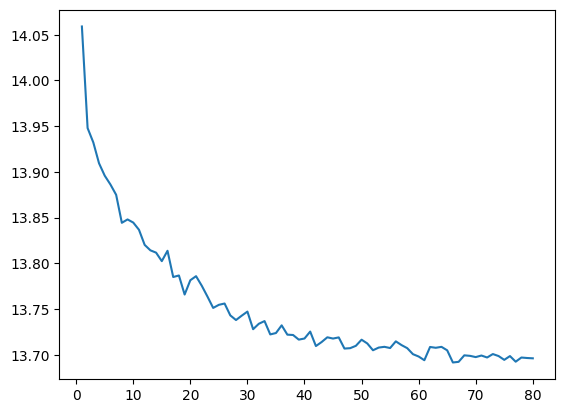

In [3]:
schsc.train(adata, target_clusters = nclusters, dims = 32, batch_size = 500, drop_rate = 0.5,
              iterations = 80, lr = 0.00001, sep = 3,  
              alpha = 0.5, beta = 1, tau = 0.9, louvain = True, leiden = False, 
              patience=5, delta=0)
plt.plot(range(1,len(schsc.loss_list)+1),schsc.loss_list)

## Evaluation

In [4]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score
from scHSC.utils import accuracy
ari = adjusted_rand_score(adata.obs["reassign_cluster"],adata.obs["cluster"])
nmi = normalized_mutual_info_score(adata.obs["reassign_cluster"],adata.obs["cluster"])
acc = accuracy(adata.obs["reassign_cluster"],adata.obs["cluster"])
print("NMI={}".format(nmi))
print("ARI={}".format(ari))
print("ACC={}".format(acc))

NMI=0.9934116738940315
ARI=0.9976447270992587
ACC=0.9992


## Visulization of Clustering Results

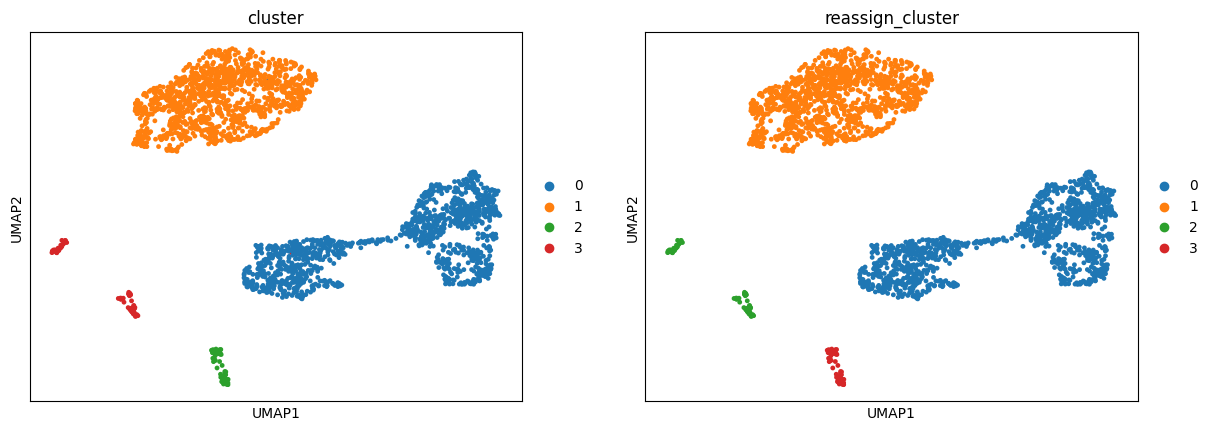

In [5]:
sc.pp.neighbors(adata,random_state=0,use_rep="X_schsc")
sc.tl.umap(adata)
adata.obs['cluster'] = adata.obs['cluster'].astype('category')
sc.pl.umap(adata,color=["cluster","reassign_cluster"])